In [ ]:
!pip install python-whois
!pip install googlesearch-python
!pip install filetype

In [122]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
import whois, re
from urllib.parse import urlparse
import os

In [123]:
def df_normalize(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')  
    string_columns = list(df.dtypes[df.dtypes == 'object'].index)  
    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_') 
        df[col] = df[col].fillna('')
    for col in [c for c in df.columns if c not in string_columns]: 
        df[col] = df[col].fillna(df[col].mean())
        df[col] = df[col].astype(int)  
    df.sex = (df.sex == 'male').astype(int)  
    df.drop(['name','ticket','cabin', 'passengerid'], axis=1, inplace=True)
    print(df.info())
    return df  
def onehot(df):
    string_columns = list(df.dtypes[df.dtypes == 'object'].index) 
    for col in string_columns:
        df = df.copy()
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(col, axis=1) 
    return df

def find_outliers(df, col ):
    quartiles = df[col].quantile([.25,.5,.75])
    Q1 = quartiles[0.25]
    Q3 = quartiles[0.75]
    IQR = Q3-Q1 
    lb = Q1 - (1.5*IQR)
    ub = Q3 + (1.5*IQR)
    print( str(lb) )
    print( str(ub) )    
    print(f"df=df.loc[ df['{col}'] > {lb} ]")
    print(f"df=df.loc[ df['{col}'] < {ub} ]")
  

In [124]:
def getwhois(url):
    d={}
    d[f'wi_url'] = url
    try:
        wi=whois.whois(url)
    except:
        wi = {}  
    ks=['domain_name', 'registrar', 'whois_server', 'updated_date', 'creation_date', 'expiration_date', 'name_servers', 'status', 'emails', 'dnssec', 'name', 'org', 'address', 'city', 'state', 'zipcode', 'country']
    for k in ks: 
        try:
            d[f'wi_{k}'] = wi[k]
        except:
            d[f'wi_{k}'] = None 
    return d 
#unittest = getwhois(df.iloc[700].url) 
#unittest

In [125]:
df = pd.read_csv('data/malicious_phish.csv', sep=',')   
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [126]:
dfmal = pd.read_csv('data/wi.csv', sep=',')   
dfmal.fillna(0, inplace=True)
schars=['/','.','?','%','&',';',':']
for c in '/.-?%&;:':
    dfmal[f'cnt_{c}'] = dfmal['url'].apply(lambda s: len(s.split(c))) 
dfmal[f'cnt_d'] = dfmal['url'].apply(lambda s: len(re.findall('\d',s)))
dfmal[666:690]

,wi_url,wi_domain_name,wi_registrar,wi_whois_server,wi_updated_date,wi_creation_date,wi_expiration_date,wi_name_servers,wi_status,wi_emails,...,type,cnt_/,cnt_.,cnt_-,cnt_?,cnt_%,cnt_&,cnt_;,cnt_:,cnt_d
666,bookrags.com/Sylvia_Earle,BOOKRAGS.COM,"Network Solutions, LLC",whois.networksolutions.com,2020-06-27 13:13:15,1999-12-28 22:49:21,2024-12-28 22:49:21,"['NS-1083.AWSDNS-07.ORG', 'NS-1827.AWSDNS-36.C...",ok https://icann.org/epp#ok,abuse@web.com,...,benign,2,2,1,1,1,1,1,1,0
667,metrolyrics.com/one-last-kiss-lyrics-mims.html,METROLYRICS.COM,"BRANDSIGHT, INC.",whois.brandsight.com,2021-01-22 22:25:07,2002-12-30 21:42:36,2022-12-30 21:42:36,"['NS1.BRANDSIGHT-DNS.COM', 'NS1.BRANDSIGHT-DNS...",['clientTransferProhibited https://icann.org/e...,"['abuse@brandsight.com', '128634@BRANDSIGHTPRI...",...,benign,2,3,5,1,1,1,1,1,0
668,geekstinkbreath.net/greenday/billie-joe-armstr...,GEEKSTINKBREATH.NET,DYNADOT LLC,whois.dynadot.com,"[datetime.datetime(2020, 3, 28, 1, 44, 30), da...",2003-11-24 17:28:02,2021-11-24 17:28:02,"['NS1.TWOWEEKS.COM', 'NS2.TWOWEEKS.COM', 'ns1....",['clientTransferProhibited https://icann.org/e...,"['abuse@dynadot.com', 'geekstinkbreath.net@sup...",...,benign,4,2,3,1,1,1,1,1,0
669,sfbike.org/download/tubetimes/html/issue083/09...,"['SFBIKE.ORG', 'sfbike.org']",Google LLC,whois.google.com,2021-08-06 19:45:09,1997-02-13 05:00:00,2022-02-14 05:00:00,"['NS-CLOUD-C1.GOOGLEDOMAINS.COM', 'NS-CLOUD-C2...",['clientTransferProhibited https://icann.org/e...,"['registrar-abuse@google.com', '5yigoefc3e1a@c...",...,benign,6,3,1,1,1,1,1,1,9
670,livedash.com/transcript/the_late_late_show_wit...,LIVEDASH.COM,Internet Domain Service BS Corp.,whois.internet.bs,"[datetime.datetime(2021, 5, 3, 4, 28, 20), dat...",2009-05-23 19:05:30,2022-05-23 19:05:30,"['NS-CANADA.TOPDNS.COM', 'NS-UK.TOPDNS.COM', '...",['clientTransferProhibited https://icann.org/e...,"['abuse@internet.bs', 'livedash.com-owner@cust...",...,benign,8,2,1,1,1,1,1,1,15
671,mikesmarina.info/,MIKESMARINA.INFO,"Network Solutions, LLC",whois.networksolutions.com,2021-07-10 15:47:19,2005-07-24 14:01:30,2022-07-24 14:01:30,"['NS99.WORLDNIC.COM', 'NS100.WORLDNIC.COM']",clientTransferProhibited https://icann.org/epp...,abuse@web.com,...,benign,2,2,1,1,1,1,1,1,0
672,marchcrole.foodpages.ca/,foodpages.ca,Go Get Canada Domain Registrar Ltd.,whois.ca.fury.ca,2021-06-30 15:03:25,2004-07-30 03:23:33,2022-07-29 04:00:00,0,0,Please ask the Registrar of Record identified ...,...,benign,2,3,1,1,1,1,1,1,0
673,en.wikipedia.org/wiki/Estadio_Nacional_(Lima),"['WIKIPEDIA.ORG', 'wikipedia.org']","MarkMonitor, Inc.",whois.markmonitor.com,"[datetime.datetime(2020, 10, 15, 22, 29, 57), ...","[datetime.datetime(2001, 1, 13, 0, 12, 14), da...","[datetime.datetime(2023, 1, 13, 0, 12, 14), da...","['NS0.WIKIMEDIA.ORG', 'NS1.WIKIMEDIA.ORG', 'NS...",['clientDeleteProhibited https://icann.org/epp...,"['abusecomplaints@markmonitor.com', 'whoisrequ...",...,benign,3,3,1,1,1,1,1,1,0
674,skimtube.com/Lara-Roxx.html,"['SKIMTUBE.COM', 'skimtube.com']",NAMECHEAP INC,whois.namecheap.com,"[datetime.datetime(2021, 6, 22, 7, 5), datetim...",2008-06-21 06:55:27,"[datetime.datetime(2022, 6, 21, 6, 55, 27), da...","['DNS101.REGISTRAR-SERVERS.COM', 'DNS102.REGIS...",clientTransferProhibited https://icann.org/epp...,"['abuse@namecheap.com', 'reactivation-pending@...",...,benign,2,3,2,1,1,1,1,1,0
675,theoppressedlittlefetus.tumblr.com/,TUMBLR.COM,MarkMonitor Inc.,whois.markmonitor.com,2019-12-19 16:59:23,2006-06-08 22:11:40,2023-06-08 22:11:40,"['NS1.TUMBLR.COM', 'NS2.TUMBLR.COM', 'NS3.TUMB...",['clientDeleteProhibited https://icann.org/epp...,abusecomplaints@markmonitor.com,...,benign,2,3,1,1,1,1,1,1,0


In [127]:
def populate_urlpars(df):
    df=df.copy()
    l=[] 
    for i,r in df.iterrows():   
        pars = urlparse(r.url) 
        d={}
        d['url']=r.url
        d['scheme']=pars.scheme
        d['netloc']=pars.netloc
        d['path']=pars.path
        d['params']=pars.params
        d['query']=pars.query
        d['frag']=pars.fragment
        d['domain_name']=f'{pars.path}/'.split('/')[0] 
        l.append( d ) 
    dff = pd.DataFrame(l) 
    return dff
dff_urlpars=populate_urlpars(dfmal)
dff_urlpars.head(2)

,url,scheme,netloc,path,params,query,frag,domain_name
0,br-icloud.com.br,,,br-icloud.com.br,,,,br-icloud.com.br
1,http://www.newtec.ac.uk/courses/health-and-soc...,http,www.newtec.ac.uk,/courses/health-and-social-care/level-2-diplom...,,,,


In [128]:
def get_path_ext(s):
    filename, file_extension = os.path.splitext(s) 
    return file_extension.replace('.','')
def is_ip(url):
    m = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'   
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' 
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  
    if m: 
        return 1
    else: 
        return 0
dfmal['is_ip'] = dfmal['wi_url'].apply(lambda s: is_ip(s))

In [129]:
dfm = pd.merge(dfmal ,dff_urlpars, left_on='url', right_on='url', suffixes=(False, False))
dfm.head(2)

,wi_url,wi_domain_name,wi_registrar,wi_whois_server,wi_updated_date,wi_creation_date,wi_expiration_date,wi_name_servers,wi_status,wi_emails,...,cnt_:,cnt_d,is_ip,scheme,netloc,path,params,query,frag,domain_name
0,br-icloud.com.br,0,0,0,0,0,0,0,0,0,...,1,0,0,,,br-icloud.com.br,,,,br-icloud.com.br
1,http://www.newtec.ac.uk/courses/health-and-soc...,ac.uk,No registrar listed. This domain is directly ...,0,0,before Aug-1996,0,ns0.ja.net.,No registration status listed.,0,...,2,1,0,http,www.newtec.ac.uk,/courses/health-and-social-care/level-2-diplom...,,,,


In [133]:
for c in [c for c in dfm.columns if re.search('wi_',c)]:
    dfm[f"has_{c.replace('wi_','')}"]=dfm[f'{c}'].apply(lambda s: 0 if (s==0 or 'No reg' in s) else 1) 
dfm.has_registrar

0        0
1        0
2        1
3        1
4        1
        ..
13151    1
13152    1
13153    1
13154    1
13155    1
Name: has_registrar, Length: 13156, dtype: int64

In [134]:

dfm['path_ext'] = dfm['path'].apply(get_path_ext)
dfm['path_ext_len'] = dfm['path_ext'].apply(lambda s: len(s))
dfm['path_pth_len'] = dfm['path'].apply(lambda s: len(s))
dfm['query_len'] = dfm['query'].apply(lambda s: len(s))  
dfm.head(2)

,wi_url,wi_domain_name,wi_registrar,wi_whois_server,wi_updated_date,wi_creation_date,wi_expiration_date,wi_name_servers,wi_status,wi_emails,...,has_org,has_address,has_city,has_state,has_zipcode,has_country,path_ext,path_ext_len,path_pth_len,query_len
0,br-icloud.com.br,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,br,2,16,0
1,http://www.newtec.ac.uk/courses/health-and-soc...,ac.uk,No registrar listed. This domain is directly ...,0,0,before Aug-1996,0,ns0.ja.net.,No registration status listed.,0,...,0,0,0,0,0,0,html,4,77,0


In [135]:
dfm.loc[dfm['is_ip']==1][['wi_url','type']].type.value_counts()

malware     136
phishing     10
benign        2
Name: type, dtype: int64

<AxesSubplot:>

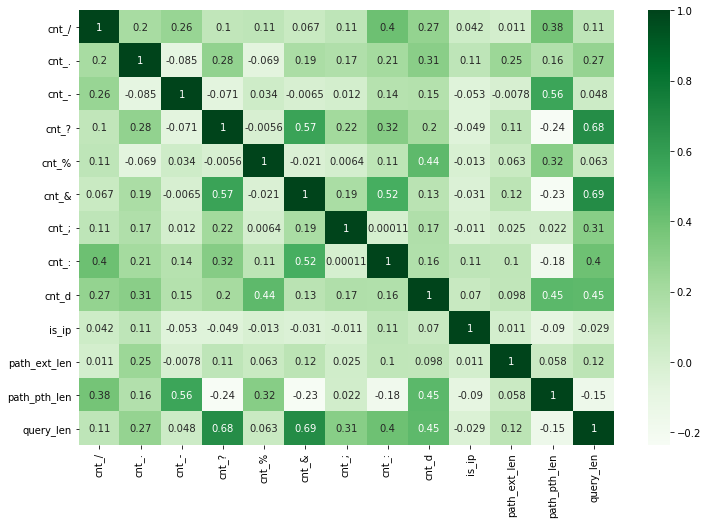

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(dfm.corr(), cmap="Greens",annot=True)

In [49]:
#dfm=dfm.loc[ dfm['path_pth_len'] < 107.5 ]
find_outliers(dfm, 'path_pth_len' )
find_outliers(dfm, 'path_ext_len' )

-26.0
102.0
df=df.loc[ df['path_pth_len'] > -26.0 ]
df=df.loc[ df['path_pth_len'] < 102.0 ]
-4.5
7.5
df=df.loc[ df['path_ext_len'] > -4.5 ]
df=df.loc[ df['path_ext_len'] < 7.5 ]


In [50]:
dfm=dfm.loc[ dfm['path_pth_len'] < 107.5 ]
dfm=dfm.loc[ dfm['path_ext_len'] < 7.5 ]

<AxesSubplot:xlabel='path_pth_len', ylabel='Density'>

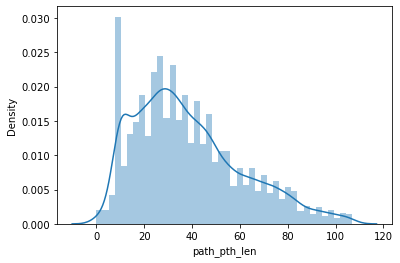

In [51]:
sns.distplot(dfm.path_pth_len)

<AxesSubplot:xlabel='path_pth_len'>

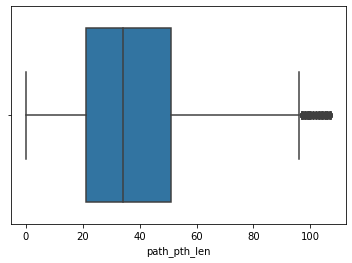

In [52]:
sns.boxplot(dfm.path_pth_len)

In [77]:
dfg=dfm.groupby('type', as_index=False).agg({'is_ip':'sum'})
dfg

,type,is_ip
0,benign,2
1,defacement,0
2,malware,135
3,phishing,10


<AxesSubplot:xlabel='type', ylabel='is_ip'>

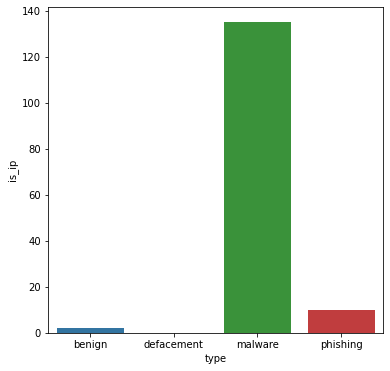

In [105]:
dfg=dfm.groupby('type', as_index=False).agg({'is_ip':'sum'})
plt.figure(figsize=(6,6))
sns.barplot(x="type", y="is_ip", data=dfg)

SyntaxError: invalid syntax (<ipython-input-121-9e22c7e6ec1d>, line 2)

In [117]:

dfg=dfm.groupby(['type'], as_index=False).agg({'has_email':'sum' }) 
dfg.sort_values('has_email', ascending=False, inplace=True)
dfg[:45]

,type,has_email
0,benign,6660
3,phishing,1062
1,defacement,570
2,malware,430


<AxesSubplot:xlabel='wi_country', ylabel='wi_url'>

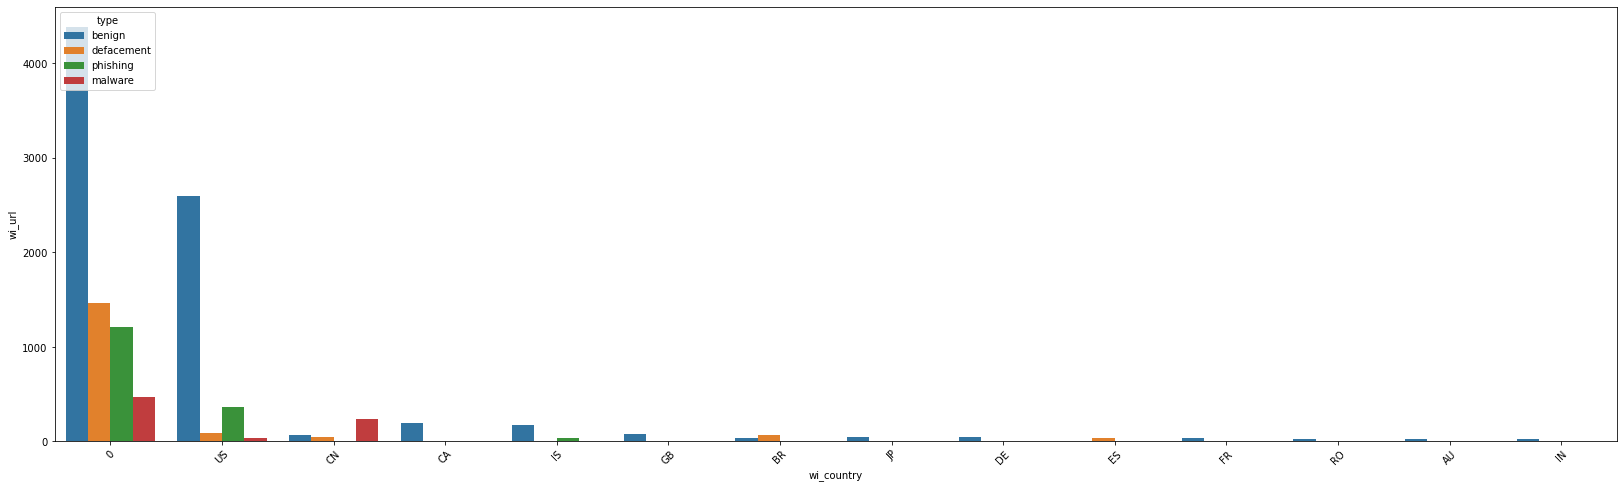

In [108]:
plt.figure(figsize=(28,8))
plt.xticks(rotation = 45) 
sns.barplot(x="wi_country", y="wi_url", hue='type', data=dfg[:24] )

In [13]:
le = preprocessing.LabelEncoder()
dfm['typ'] = le.fit_transform(dfm.type)

In [15]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13156 entries, 0 to 13155
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          13156 non-null  object
 1   is_ip         13156 non-null  int64 
 2   scheme        13156 non-null  object
 3   netloc        13156 non-null  object
 4   path          13156 non-null  object
 5   params        13156 non-null  object
 6   query         13156 non-null  object
 7   frag          13156 non-null  object
 8   domain_name   13156 non-null  object
 9   path_ext      13156 non-null  object
 10  path_ext_len  13156 non-null  int64 
 11  path_pth_len  13156 non-null  int64 
 12  query_len     13156 non-null  int64 
 13  typ           13156 non-null  int32 
dtypes: int32(1), int64(4), object(9)
memory usage: 1.5+ MB


In [79]:

sns.barplot(dfm.wi_country)

TypeError: Horizontal orientation requires numeric `x` variable.

In [ ]:
dfm.loc[dfm.path_pth_len < 20][:2]

In [ ]:
print(len(df))
df.type.value_counts() / len(df)

In [ ]:
df1=df[0:len(df):50]
print(len(df1))
df1.type.value_counts() / len(df1)

In [ ]:
def populate_dataset(df):
    df=df.copy()
    l=[] 
    for i,r in df.iterrows():  
        try:
            wi=getwhois(r.url)
        except:
            wi={} 
        wi['url']=r.url    
        wi['type']=r.type  
        l.append( wi ) 
    dff = pd.DataFrame(l)
    dff.to_csv(f'data/malicious_phish_wi_samples_{len(df1)}.csv', index=False) 
    return dff
dff=populate_dataset(df1)
dff

In [ ]:
df = df_normalize( df )

In [ ]:
df['famsize'] = df.sibsp + df.parch

In [ ]:
sns.pairplot(df, hue='survived', size=3 ); 

In [ ]:
find_outliers(df,'fare')
sns.boxplot(df['fare']);  

In [ ]:
df=df.loc[ df['fare'] > -29.0 ]
df=df.loc[ df['fare'] < 367.0 ]
sns.pairplot(df, hue='survived', size=3 ); 

In [ ]:
df['age_bin'] = pd.cut(df['age'],  bins=[0, 20, 40, 60, 90], labels=[1,2,3,4])
df['fare_bin'] = pd.cut(df['fare'],  bins=[0, 25, 50, 100, 150], labels=[1,2,3,4])
sns.distplot(df.fare_bin)

In [ ]:
dff = onehot(df) 
dff

In [ ]:
#df['age_bin'] = pd.cut(df['age'],  bins=[0, 20, 40, 60, 90], labels=[1,2,3,4])
#df

In [ ]:
df_clean = df

In [ ]:
quartiles = df['fare'].quantile([.25,.5,.75])
Q1 = quartiles[0.25]
Q3 = quartiles[0.75]
IQR = Q3-Q1

lb = Q1 - (1.5*IQR)
ub = Q3 + (1.5*IQR)

In [ ]:
df = df.loc[ df.fare < ub]
sns.distplot(df.fare)


In [ ]:
sns.heatmap(df.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [ ]:
y = df['survived'].values 
X = df.drop(['survived'], axis=1).values 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

In [ ]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f} / {test_score:.3f}")
     
plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing r2 Score")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

In [ ]:
print ( y_train[15] ) 
df.iloc[15].values

In [ ]:
pred = knn.predict([[ 2,  0, 55,  0,  0, 116,  3]])
pred

In [ ]:
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization) Ridge": Ridge(),
    " Linear Regression (L1 Regularization) Lasso": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(), 
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor()
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.") 
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test))) 

In [ ]:
model = Ridge()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
pred = model.predict(X_test)
df_pred = pd.DataFrame({ 'pred': pred, 'act': y_test, 'err': pred-y_test  })
df_pred